In [157]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import ast


In [ ]:
def fetch_movies(url, headers):

    response = requests.get(url, headers=headers)

    soup = BeautifulSoup(response.content, "html.parser")
    return soup

In [ ]:
#Used to extract data from IMDb websites
from re import I
def extract_movie_stars(soup):
    all_cast = soup.find_all('td', class_= None)
    cast = []
    count = 0
    if all_cast:
      for member in all_cast:
          if member and member.find('a'):
            count += 1
            cast.append(member.find('a').text.strip())
          if count == 10:
            break

    composer_header = soup.find('h4', id='composer')
    if composer_header is None:
        return cast, ""

    composer_table = composer_header.find_next_sibling('table')

    composer_name = None
    if composer_table:

        composer_link = composer_table.find('a')
        if composer_link:
            composer_name = composer_link.text.strip()
        return cast, composer_name

def extract_movie_data(soup):
    name = soup.find('span',class_='hero__primary-text').text.strip()
    print(name)
    syn = soup.find('span', class_='sc-3ac15c8d-0 hRUoSB').text.strip()
    writers = []
    director = []
    cast_mem = []
    composer = ""
    prod = ""
    date = ""
    all_credits = soup.find_all('li', class_='ipc-metadata-list__item')

    if all_credits:
      for credit in all_credits:
          label = credit.find('span', class_='ipc-metadata-list-item__label ipc-metadata-list-item__label--btn')

          if label and label.text.strip().startswith("Writer"):
              writers = [a.text for a in credit.find_all('a', class_='ipc-metadata-list-item__list-content-item--link')]
          elif label and label.text.strip().startswith("Director"):
              director = [a.text for a in credit.find_all('a', class_='ipc-metadata-list-item__list-content-item--link')]

    all_details = soup.find_all('li', class_='ipc-metadata-list__item ipc-metadata-list-item--link', )
    if all_details:
      for detail in all_details:
          if detail and detail.text.strip().startswith("Release"):
              date = detail.find('a', class_='ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link').text.strip().split('(')[0]
          elif detail and detail.text.strip().startswith("Production"):
              prod = [a.text for a in detail.find_all('a', class_='ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link')]
          cast = detail.find('a', class_='ipc-metadata-list-item__label ipc-metadata-list-item__label--link')
          if cast and cast.text.strip().startswith("Star"):
              cast_link = cast.get('href')
              cast_url = "https://www.imdb.com" + cast_link
              headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
              cast_soup = fetch_movies(cast_url, headers)
              cast_mem, composer = extract_movie_stars(cast_soup)

    movie_data = [name, syn, date, writers, director, prod, composer, cast_mem]

    return movie_data

def extract_movie_links(soup):
    movie_data = []

    movie_names = soup.find_all('h3', class_='ipc-title__text')
    links = soup.find_all('a', class_='ipc-title-link-wrapper')
    movie_links = []
    movie_data = []
    for link in links:
      whole_link = "https://www.imdb.com" + link.get('href')
      movie_links.append(whole_link)
      headers = {
      'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
      soup2 = fetch_movies(whole_link,headers)
      movie_data.append(extract_movie_data(soup2))

    return movie_data

In [ ]:
#to gen
import calendar
from datetime import datetime

year = 2022

# List to store all generated URLs
urls = []

for month in range(1, 13):

    # Get the number of days in the current month
    last_day = calendar.monthrange(year, month)[1]

    month_str = f"{month:02d}"

    url = f"https://www.imdb.com/search/title/?title_type=feature&release_date={year}-{month_str}-01,{year}-{month_str}-{last_day}&primary_language=te"

    urls.append(url)

print(urls)

['https://www.imdb.com/search/title/?title_type=feature&release_date=2022-01-01,2022-01-31&primary_language=te', 'https://www.imdb.com/search/title/?title_type=feature&release_date=2022-02-01,2022-02-28&primary_language=te', 'https://www.imdb.com/search/title/?title_type=feature&release_date=2022-03-01,2022-03-31&primary_language=te', 'https://www.imdb.com/search/title/?title_type=feature&release_date=2022-04-01,2022-04-30&primary_language=te', 'https://www.imdb.com/search/title/?title_type=feature&release_date=2022-05-01,2022-05-31&primary_language=te', 'https://www.imdb.com/search/title/?title_type=feature&release_date=2022-06-01,2022-06-30&primary_language=te', 'https://www.imdb.com/search/title/?title_type=feature&release_date=2022-07-01,2022-07-31&primary_language=te', 'https://www.imdb.com/search/title/?title_type=feature&release_date=2022-08-01,2022-08-31&primary_language=te', 'https://www.imdb.com/search/title/?title_type=feature&release_date=2022-09-01,2022-09-30&primary_langu

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
columns = ['name', 'syn', 'date', 'writers', 'director', 'prod', 'composer', 'cast_mem']
data = []
soup = fetch_movies(urls[0], headers)
data = extract_movie_links(soup)
df = pd.DataFrame(data, columns=columns)
df['writers'] = df['writers'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
df['director'] = df['director'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
df['prod'] = df['prod'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
df['cast_mem'] = df['cast_mem'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
# Fetch and parse the HTML content from the given URL

for url in urls:
  data = []
  soup = fetch_movies(url, headers)
  data = extract_movie_links(soup)
  if url != urls[0]:
    df2 = pd.DataFrame(data, columns=columns)

    #clean the data
    df2['writers'] = df2['writers'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
    df2['director'] = df2['director'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
    df2['prod'] = df2['prod'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
    df2['cast_mem'] = df2['cast_mem'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
    df = pd.concat([df, df2], ignore_index=True)

print(df)

Adhurs
Sambo Siva Sambho
Namo Venkatesa
Om Shanti
Seetharamula Kalyanam Lankalo
Comedy Express
Udatha Udatha Ooch
Maa Nanna Chiranjeevi
Premistu
Yugalageetham
Maarpu
Adhurs
Sambo Siva Sambho
Namo Venkatesa
Om Shanti
Seetharamula Kalyanam Lankalo
Comedy Express
Udatha Udatha Ooch
Maa Nanna Chiranjeevi
Premistu
Yugalageetham
Maarpu
Ye Maaya Chesave
Leader
Kedi
Bindaas
Inkosari
Kalavar King
Jai Bhadrakali
Tejam
High School
Varudu
Saadhyam
Tik Tik Tik
Taj Mahal
Maro Charitra
Dammunnodu
Yagam
Aakasa Ramanna
Prema Rajyam
Sandadi
Prasthanam
Darling
Simha
Betting Bangarraju
Police Police
Mouna Ragam
1940 lo Oka Gramam
Srimati Kalyanam
Dhoom Dhaam
Madhanudu
Anaganaga Oka Aranyam
Golimar
Rama Rama Krishna Krishna
Andari Bandhuvaya
Chalaki
Aaha yentha andam
My Name Is Amrutha
Young India
Vedam
Panchakshari
Pappu
Jhummandi Naadam
Maryada Ramanna
Sneha Geetham
Bheemli Kabadi Jattu
Subhapradam
Brahmalokam to Yamalokam Via Bhoolokam
Em Pillo Em Pillado
Maa annaya bangaram
Kothi Mooka
Maa Annayya Bang

In [ ]:
df.to_csv("movies_data2022.csv", index=False)

In [112]:
#used to drop empty columns in scraped IMDb data
file_path = 'movies_data.csv'
data = pd.read_csv(file_path)

filtered_data = data.dropna(subset=['prod','cast_mem', 'director'])

filtered_data.to_csv('cleaned_movies.csv', index=False)

print(f"Cleaned data saved to cleaned_movies.csv")

Cleaned data saved to cleaned_movies.csv


In [163]:
#to do one-hot encoding and drop unimportant features

file_path = 'regional_box_office.csv'
data = pd.read_csv(file_path)


# Function to convert lists of strings in cast producers and directors to actual lists
def safe_eval_list(x):
    if pd.isna(x):
        return []
    try:
        return ast.literal_eval(x)
    except:
        return [name.strip() for name in x.split(',')]

list_columns = ['cast', 'producer', 'director']
for col in list_columns:
    if col in data.columns:
        data[col] = data[col].apply(safe_eval_list)

# Function to one-hot encode columns
def one_hot_encode_list_column(df, column_name):
    if column_name in df.columns:
        exploded = df.explode(column_name)
        dummies = pd.get_dummies(exploded[column_name].str.strip())
        dummies = dummies.groupby(dummies.index).sum()
        return dummies
    return pd.DataFrame()

# One-hot encode list columns
cast_encoded = one_hot_encode_list_column(data, 'cast')
producers_encoded = one_hot_encode_list_column(data, 'producer')
directors_encoded = one_hot_encode_list_column(data, 'director')
composer_encoded = one_hot_encode_list_column(data, 'composer')
month_encoded = pd.get_dummies(data['month'])

# Combining all encoded features back into the dataset
data_encoded = pd.concat([data, cast_encoded, producers_encoded, directors_encoded, month_encoded, composer_encoded], axis=1)

names = data_encoded['title']

# Dropping original categorical columns
data_encoded.drop(columns=['title','cast', 'producer', 'director', 'month', 'composer'], inplace=True, errors='ignore')

filtering_data = data_encoded.iloc[:, 10:]
#finding out which features appear the most often and only keeping the top 50 to limit the number of features we have
column_impacts = filtering_data.sum()

best_columns = column_impacts.sort_values(ascending=False).head(50)

top_columns = best_columns.index.tolist()
keep_columns = ['nizam', 'ceded', 'vizag', 'east', 'west', 'krishna', 'guntur', 'nellore', 'WW'] + top_columns
data_encoded = data_encoded[keep_columns]

data_encoded.to_csv('filtered_encoded_movies_data.csv', index=False)


In [165]:
#Implementing Lasso Regression

def normalize(X_train, X_test):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  return X_train_scaled, X_test_scaled

def lasso_regression(X, y, al, X_te, y_te):
  lasso = Lasso(alpha = al)
  lasso.fit(X, y)
  y_pred = lasso.predict(X_te)
  mse = np.mean((y_te - y_pred)**2)
  coefficients = lasso.coef_
  return y_pred, coefficients, mse

X = data_encoded[top_columns].to_numpy()
Y = pd.DataFrame(data_encoded[['nizam', 'ceded', 'vizag', 'east', 'west', 'krishna', 'guntur', 'nellore', 'WW']])
Y = Y.to_numpy()
split = int(len(X)*0.8)
X_tr = X[:split,:]
X_te = X[split:,:]
Y_tr = Y[:split,:]
Y_te = Y[split:,:]

X_tr, X_te = normalize(X_tr, X_te)

coefficients = []
predicted_box_office = []
mserrors = []
alphas = [0.4, 0.3, 0.2, 0.1, 0.1, 0.1, 0.1,0.1,0.5]
for region in range(Y.shape[1]):
  pred, coeff, mse = lasso_regression(X_tr, Y_tr[:,region], alphas[region], X_te, Y_te[:,region])
  coefficients.append(coeff)
  predicted_box_office.append(pred)
  mserrors.append(mse)


final_coefficients = np.array(coefficients)

final_predicted_box_office = np.array(predicted_box_office)

print("Final MSE Values by region:")
final_mserrors = np.array(mse)
print(mserrors)

Final MSE Values by region:
[184.0162479195493, 34.36403686541252, 26.76606964459071, 7.1906483901858, 3.14461092577017, 4.408703467936739, 7.796298778514117, 1.562188813115136, 8678.918164508776]


In [166]:
#to save the coefficients in a csv file
coefficients_dict = {}

regions = ['nizam', 'ceded', 'vizag', 'east', 'west', 'krishna', 'guntur', 'nellore', 'WW']

for i, coeffs in enumerate(final_coefficients):
    region = regions[i]
    coefficients_dict[region] = coeffs

coefficients_df = pd.DataFrame(coefficients_dict)
coefficients_df.insert(0, 'Features', top_columns)

coefficients_df.to_excel('coefficients_data.xlsx', index=False)

names = names[split:]
final_df = pd.DataFrame({
    'Movie Name': names
})

#to save the box office predictions for each region
for region, preds in zip(regions, predicted_box_office):
    final_df[f'{region} Prediction'] = preds
    final_df[f'{region} Actual Values'] = Y_te[:, regions.index(region)]

# Save all predictions to a single sheet in an Excel file
final_df.to_excel('all_movie_predictions.xlsx', index=False)

print("All predictions were saved in all_movie_predictions.xlsx")

All predictions were saved in all_movie_predictions.xlsx


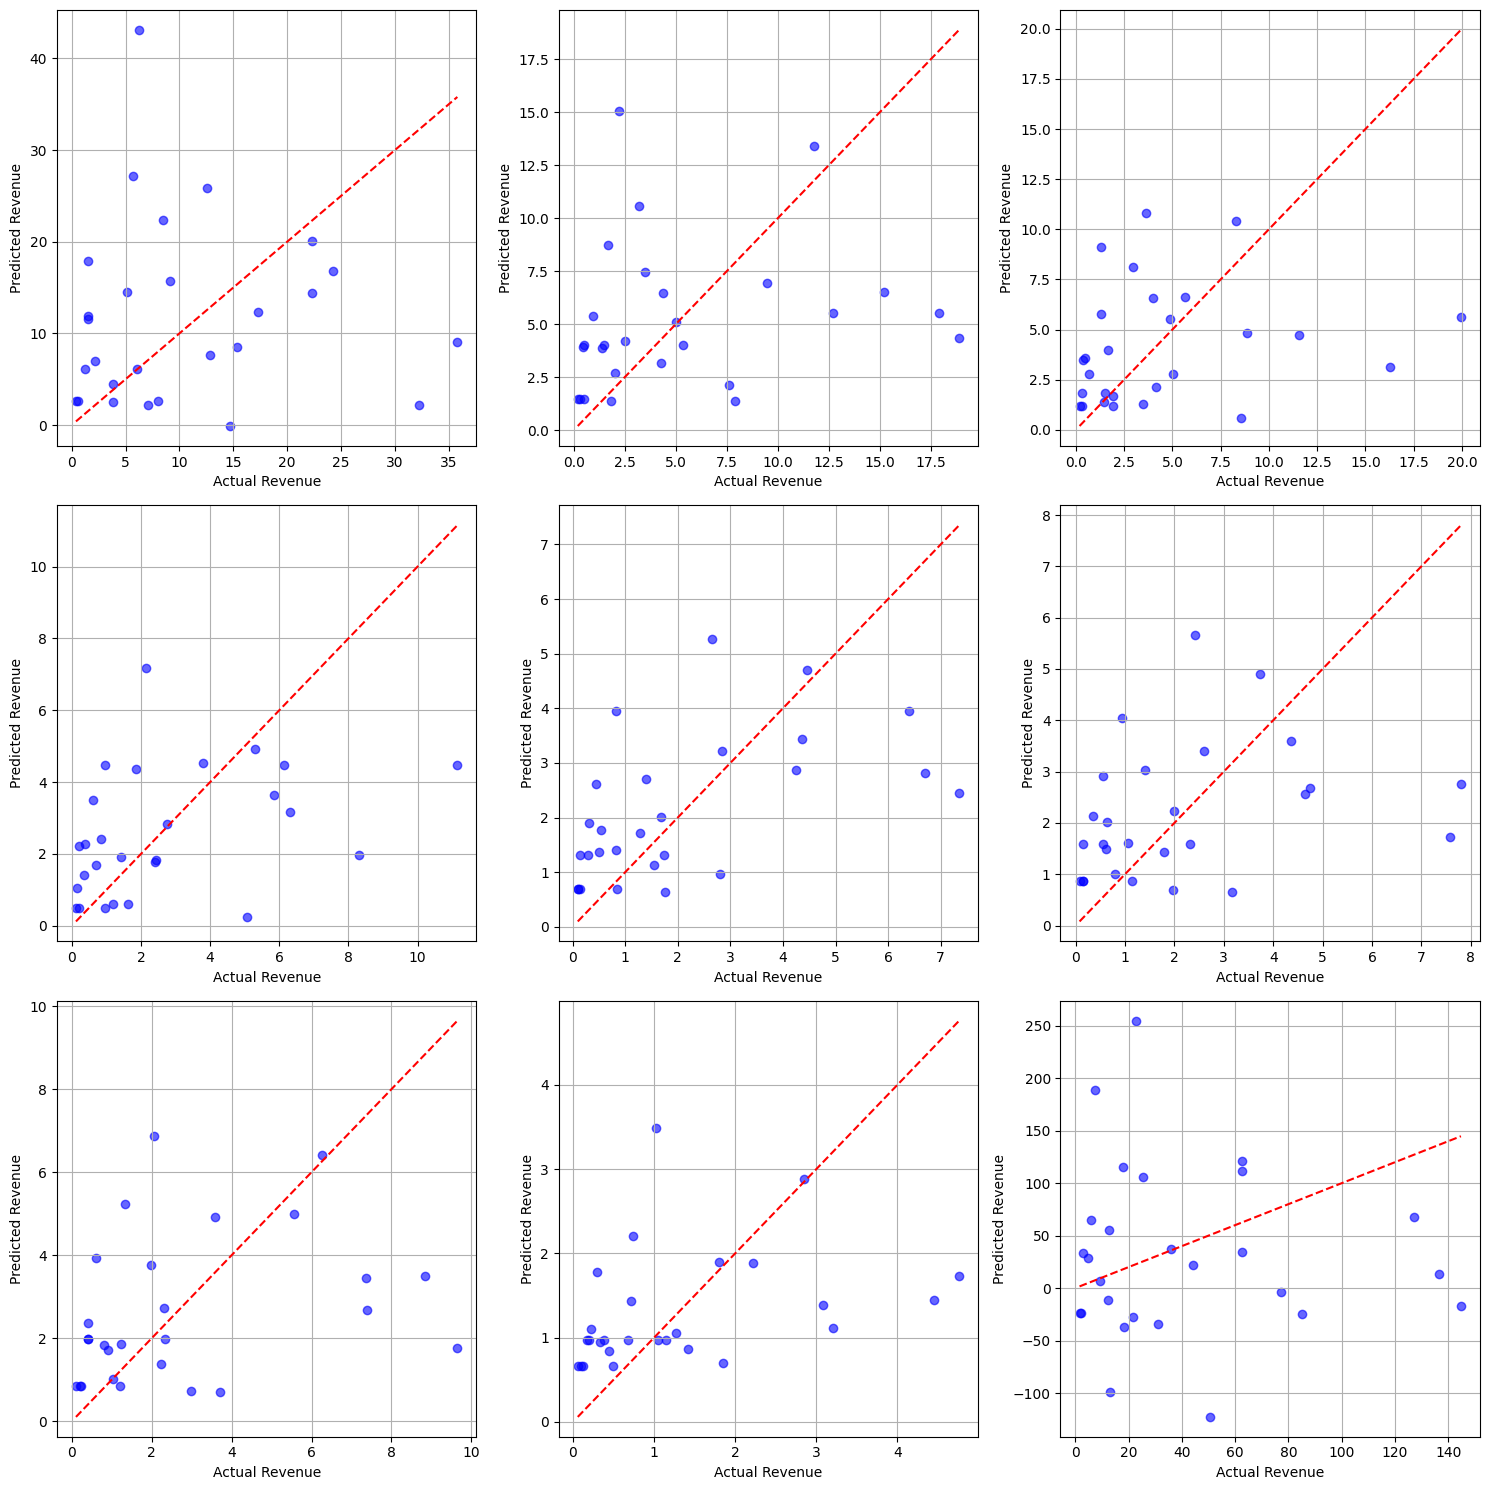

In [168]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3x3 grid for 9 regions

axes = axes.flatten()

# Loop through each region and plot
for i, region in enumerate(regions):

    actual = Y_te[:, i]
    predicted = predicted_box_office[i]

    axes[i].scatter(actual, predicted, color='blue', alpha=0.6)
    axes[i].plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')
    axes[i].set_xlabel('Actual Revenue')
    axes[i].set_ylabel('Predicted Revenue')
    axes[i].grid(True)

plt.tight_layout()

plt.show()